In [0]:
## Import important libraries

import pandas as pd
import numpy as np

from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap, geom_histogram, scale_x_log10
from plotnine import geom_boxplot, scale_y_log10, geom_bar, geom_line, ggtitle
from scipy.stats import pearsonr
import itertools
import scipy.stats as scs
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [0]:
# Import File

filepath = './dataset/OUTPUT_WBI_exposer_cyclones_v6.csv'
df = pd.read_csv(filepath)

In [0]:
# Drop some unimportant features
df = df.drop(columns=['pop_max_34', 'pop_max_50', 'pop_max_64', 'Unnamed: 0', "SID"])

In [0]:
### Xaview Preprocessing


df["SUB BASIN"]= df["SUB BASIN"].replace('MM', np.nan) 
df["BASIN"]= df["BASIN"].replace('MM', np.nan)

df['SUB BASIN']= np.where(df['SUB BASIN'].isnull(), df['BASIN'], df['SUB BASIN'])

df["USA_SSHS"]= df["USA_SSHS"].replace(-5, np.nan)



df["TOTAL_DAMAGE_(000$)_Adjusted"]= df["TOTAL_DAMAGE_(000$)"] / df["CPI"]
df["TOTAL_DAMAGE_(000$)_Adjusted"]= df["TOTAL_DAMAGE_(000$)_Adjusted"].replace(0, np.nan)
df = df.drop(["TOTAL_DAMAGE_(000$)",'CPI'], axis=1)


In [0]:

## Binary column for whether SSHSS falls within 1-5 category scale
df['SSHSS'] = np.where(df['USA_SSHS'] > 0, 1, 0)

df["SSHSS"] = df["SSHSS"].astype('object')

columns = ['BASIN', 'SUB BASIN', 'NATURE', 'Income_level_Final', 'USA_SSHS', 'SSHSS']

In [0]:
## Check features no null count

def checkNull(col, df):
  return(df[col].isna().sum() / len(df[col]) * 100.0)
  
for each in df.columns.values:
  print('{} ---- {}'.format(each, checkNull(each, df)))

NAME ---- 0.0
ISO ---- 0.0
YEAR ---- 0.0
BASIN ---- 0.0
SUB BASIN ---- 0.0
NATURE ---- 0.0
ISO_TIME ---- 0.0
COORDS ---- 0.0
TOTAL_HRS ---- 0.0
DAY_HRS ---- 0.0
NIGHT_HRS ---- 0.0
USA_SSHS ---- 0.6704980842911877
WIND_CAL_MIN ---- 0.0
WIND_CAL_MAX ---- 0.0
WIND_CALC_MEAN ---- 0.38314176245210724
PRES_CAL_MIN ---- 0.0
PRES_CAL_MAX ---- 0.0
PRES_CALC_MEAN ---- 0.0
STORM_SPD_MIN ---- 0.0
STORM_SPD_MAX ---- 0.0
STORM_SPD_MEAN ---- 0.0
STORM_DR_MIN ---- 0.0
STORM_DR_MAX ---- 0.0
STORM_DR_MEAN ---- 0.0
V_LAND_KN ---- 0.0
34KN_ASSETS ---- 23.371647509578544
64KN_ASSETS ---- 23.371647509578544
96KN_ASSETS ---- 23.371647509578544
TOTAL_DEATHS ---- 13.505747126436782
Air transport, freight (million ton-km) ---- 15.996168582375478
Arable land (hectares per person) ---- 0.09578544061302681
Cereal yield (kg per hectare) ---- 0.9578544061302682
Food production index (2004-2006 = 100) ---- 0.38314176245210724
GDP growth (annual %) ---- 3.8314176245210727
GDP per capita (constant 2010 US$) ---- 0.8620

In [0]:

## Drop columns with NaNs - Removed pending proper preprocessing of features 
## and NaNs are dealt with
all_columns = df.columns.values

to_remove = ['ID', 'NAME', 'ISO', 'Year', 'COORDS', 'ISO_TIME', '34kn_pop', 
             '34kn_assets', '64kn_pop', '64kn_assets', '96kn_pop', '96kn_assets',
             "Total damage ('000$)", 'Air transport, freight (million ton-km)']

to_remove.extend(['TOTAL_DAMAGE_(000$)_Adjusted', 'TOTAL_DEATHS', 
                  'Air transport, freight (million ton-km)', 'YEAR',
                  '34KN_ASSETS', '64KN_ASSETS', '96KN_ASSETS'])


regression_columns = [x for x in all_columns if x not in to_remove]

no_na_df = df[regression_columns].dropna()





In [0]:
## Create dummies for categorical features

object_columns = [col for col in regression_columns if df[col].dtype == 'object']
dummies = pd.get_dummies(no_na_df[object_columns])



no_na_df = pd.concat([no_na_df, dummies], axis=1)

object_columns.append('SSHSS_1')
no_na_df = no_na_df.drop(columns=object_columns)

In [0]:
## Split data

features = [x for x in no_na_df.columns.values if x != 'TOTAL_AFFECTED']
X_train, X_test, y_train, y_test = train_test_split(
    no_na_df[features], no_na_df['TOTAL_AFFECTED'], test_size=0.2, random_state=42)

In [0]:
# Standard scaler

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X_train)

In [0]:
train = TensorDataset(torch.Tensor(scaled_X), torch.Tensor(y_train.values).view(-1, 1))
train_loader = DataLoader(train, shuffle = True, batch_size = 32)

In [0]:
# Model Architecture
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.h1 = torch.nn.Linear(n_feature, n_hidden)
        self.h2 = torch.nn.Linear(n_hidden, n_hidden*2) 
        self.h3 = torch.nn.Linear(n_hidden*2, n_hidden*4) 

        self.lRelu = torch.nn.LeakyReLU(0.2)

        self.dropout = torch.nn.Dropout(0.4)

        self.out = torch.nn.Linear(n_hidden*4, n_output)

    def forward(self, x):
        x = self.lRelu(self.h1(x))      
        x = self.dropout(x)

        x = self.lRelu(self.h2(x))   
        x = self.dropout(x)

        x = self.lRelu(self.h3(x))   
        x = self.dropout(x)

        x = self.out(x)             
        return(x)


def create_model(n_features, n_hidden, n_output):
  clf = nn.Sequential(
      nn.Linear(n_features, n_hidden), 
      nn.Linear(n_hidden, n_output), 
  )

  return(clf)

In [0]:
## Loss & Optimizer setup

model = Net(X_train.shape[1], 16, 1)

optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.001)
criterion = torch.nn.MSELoss()

epochs = 10

In [0]:
## Train model

losses = []
for n in range(1, epochs):
  model.train()

  for X, Y in train_loader:

    optimizer.zero_grad()

    pred = model(X)

    loss = criterion(pred, Y)

    loss.backward()
    optimizer.step()

    losses.append(loss)

    print("Epoch - {}  Loss - {} ".format(n, loss))

Epoch - 1  Loss - 2370855501824.0 
Epoch - 1  Loss - 358282166272.0 
Epoch - 1  Loss - 1585125392384.0 
Epoch - 1  Loss - 4271835185152.0 
Epoch - 1  Loss - 516063068160.0 
Epoch - 1  Loss - 5651338625024.0 
Epoch - 1  Loss - 2199429578752.0 
Epoch - 1  Loss - 1936332292096.0 
Epoch - 1  Loss - 319217500160.0 
Epoch - 1  Loss - 15825573511168.0 
Epoch - 1  Loss - 615780581376.0 
Epoch - 1  Loss - 8590146404352.0 
Epoch - 1  Loss - 359286669312.0 
Epoch - 1  Loss - 3693128187904.0 
Epoch - 1  Loss - 14144223838208.0 
Epoch - 1  Loss - 1784162811904.0 
Epoch - 1  Loss - 1558842179584.0 
Epoch - 1  Loss - 1394948833280.0 
Epoch - 1  Loss - 573551083520.0 
Epoch - 1  Loss - 533749235712.0 
Epoch - 1  Loss - 1596759736320.0 
Epoch - 1  Loss - 5951532826624.0 
Epoch - 1  Loss - 7213441089536.0 
Epoch - 1  Loss - 136760311808.0 
Epoch - 1  Loss - 1281200750592.0 
Epoch - 2  Loss - 414834229248.0 
Epoch - 2  Loss - 53283872768.0 
Epoch - 2  Loss - 6659476815872.0 
Epoch - 2  Loss - 35423325388

In [0]:
losses = [loss.item() for loss in losses]
steps = np.arange(1, len(losses)+1)

plott = pd.DataFrame({ "steps": steps, 
                       'loss': losses})

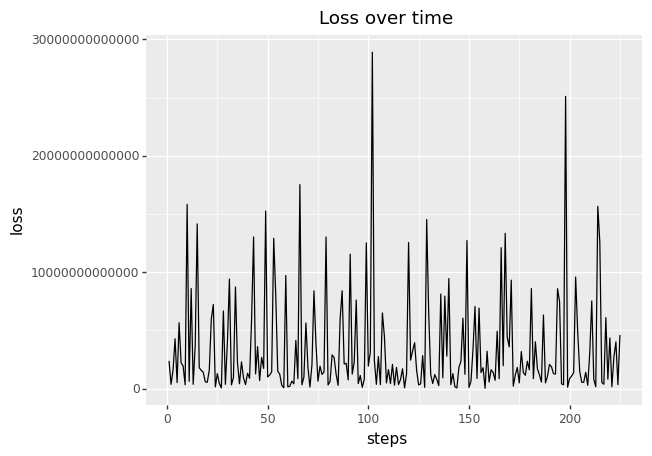

<ggplot: (8783889803128)>

In [0]:
## Visualize model loss

(ggplot(plott, aes(x='steps', y='loss'))
 + geom_line()
 + ggtitle("Loss over time"))